In [1]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer

import pandas as pd

data = pd.read_csv('Data/features_3_sec.csv')
data = data.drop(['filename'], axis=1)

y = LabelEncoder().fit_transform(data['label'])
data = data.drop(['label'], axis=1)

X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(data.shape)

(9990, 58)


In [11]:
models = []
n_samples, n_features = X_train.shape
print(n_samples, n_features)
for k in range(10):
    y_train_k = np.where(y_train == k, 1, -1)
    model = pyo.ConcreteModel()

    model.I = pyo.RangeSet(0, n_samples - 1)  # Sample indices
    model.J = pyo.RangeSet(0, n_features - 1)  # Feature indices

    def X_init(model, i, j):
        return X_train[i, j]

    def y_init(model, i):
        return y_train_k[i]
    
    model.X = pyo.Param(model.I, model.J, initialize=X_init, within=pyo.Reals)
    model.y = pyo.Param(model.I, initialize=y_init, within=pyo.Reals)

    model.w = pyo.Var(model.J, domain=pyo.Reals)  # Weight vector
    model.b = pyo.Var(domain=pyo.Reals)  # Bias term
    model.slack = pyo.Var(model.I, domain=pyo.NonNegativeReals)  # Slack variables

    C = 1.0

    def objective_rule(model):
        regularization = 0.5 * sum(model.w[j]**2 for j in model.J)
        slack = C * sum(model.slack[i] for i in model.I)
        return regularization + slack
    model.Objective = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    def constraints(model, i):
        return model.y[i] * (sum(model.w[j] * model.X[i,j] for j in model.J)
                             + model.b) >= 1 - model.slack[i]
    
    model.constraints = pyo.Constraint(model.I, rule = constraints)
    models.append(model)
    

7992 58


In [14]:
solver = pyo.SolverFactory('ipopt', executable = '/Users/aoleicao/Documents/python/6800/MacOS/ipopt')
w_list = []
b_list = []

for k, model in enumerate(models):
    print(f'solving for class {k}')
    result = solver.solve(model)

    print(f"Optimal solution found for class {k}")
        # Extract the optimal weights and bias
    w_opt = np.array([pyo.value(model.w[j]) for j in model.J])
    b_opt = pyo.value(model.b)
    w_list.append(w_opt)
    b_list.append(b_opt)

solving for class 0
Optimal solution found for class 0
solving for class 1
Optimal solution found for class 1
solving for class 2
Optimal solution found for class 2
solving for class 3
Optimal solution found for class 3
solving for class 4
Optimal solution found for class 4
solving for class 5
Optimal solution found for class 5
solving for class 6
Optimal solution found for class 6
solving for class 7
Optimal solution found for class 7
solving for class 8
Optimal solution found for class 8
solving for class 9
Optimal solution found for class 9


In [23]:
test = X_test[0]
label = y_test[0]
decision_values_sample = np.zeros(len(models))
for k in range(len(models)):
    if w_list[k] is not None:
        decision_values_sample[k] = np.dot(test, w_list[k])
        print(decision_values_sample[k])
predicted_class = np.argmax(decision_values_sample)
print(f'pppppredicted: {predicted_class} and true: {label}')

2.5805371010902842
2.149518112646749
1.1770936516731163
-0.22021461832615108
1.498966679400012
0.1046944849875513
0.4439257490358979
-2.5636811566338946
1.2773737534796399
4.723568517630072e-08
pppppredicted: 0 and true: 4


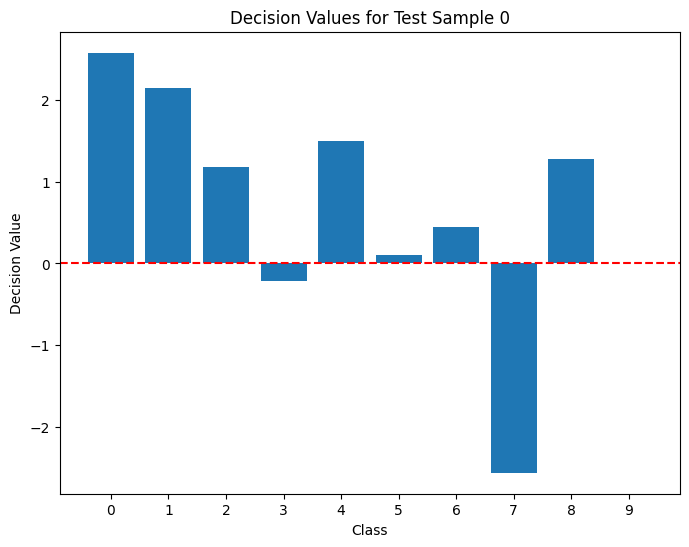

In [25]:
import matplotlib.pyplot as plt

# Plot the decision values for the selected sample
plt.figure(figsize=(8, 6))
plt.bar(range(len(models)), decision_values_sample, tick_label=range(len(models)))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Class")
plt.ylabel("Decision Value")
plt.title(f"Decision Values for Test Sample {0}")
plt.show()

In [ ]:
decision_values = np.zeros((X_test.shape[0], len(models)))  # Shape: (num_samples, num_classes)

for k in range(len(models)):
    if w_list[k] is not None:  # Ensure the model for class k solved successfully
        decision_values[:, k] = np.dot(X_test, w_list[k]) + b_list[k]

# Assign the class with the highest decision value
y_pred = np.argmax(decision_values, axis=1)

# Evaluate the results
from sklearn.metrics import classification_report, accuracy_score

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       208
           1       0.89      0.97      0.93       203
           2       0.60      0.62      0.61       186
           3       0.61      0.49      0.54       199
           4       0.76      0.71      0.73       218
           5       0.71      0.74      0.73       192
           6       0.78      0.92      0.84       204
           7       0.73      0.87      0.79       180
           8       0.69      0.62      0.65       211
           9       0.21      0.17      0.19       197

    accuracy                           0.68      1998
   macro avg       0.67      0.68      0.67      1998
weighted avg       0.67      0.68      0.67      1998

Accuracy: 0.6806806806806807
